# Localization

![](https://docs.google.com/drawings/d/e/2PACX-1vQ2SQeGNXvVybIzZW9Bp2cBFE2wQyrzh7vf6MCxzS-JAQvw-97nyyafxblGoWOAL5T8j9LwqcDWgXFV/pub?w=1121&h=204)

## Evironment Setup

In [24]:
# import libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Setup simulated world
n = 200 # the number of bins in our approximation
X = range(n) # used for graphing purposes
width = 1560 # the real length of the hallway
env_map = np.array([280.5, 480.5, 1280.5]) # the locations of the doors in the hallway

# motion parameters
x_noise = 3 # specifies how noisy our motion is (higher = noisier)
kernel_size = 6 # how big our "smoother" is
kernel = norm.pdf(np.arange(-kernel_size, kernel_size+1), scale=x_noise) # create "smoother"
kernel /= np.sum(kernel) # normalize "smoother" so sum is 1

# measurement parameters
z_noise = 0.006 # represents how noisy our door senser is (higher = noisier)
sensor_spread = 25 # simulation parameter. Represents how close to a door you have to be to sense it

# read image files
robot_img = mpimg.imread('robot.png')
doors_img = mpimg.imread('doors.png')
(h, w, _) = robot_img.shape

# function to generate a noisy measurement
def get_measurement(true_state):
    v = np.min(abs(env_map - true_state))
    return norm.pdf(v, scale=sensor_spread) + np.random.normal(scale=z_noise)

## Prediction Step
Implement the "move" step by shifting grid cells and then convolving with kernel. `prior` is the prior probability distribution (the grid cells to shift), `env_map` is a list of door locations, and `u` is how many units you shifted left or right (negative is left, positive is right).

In [25]:
def predict(prior, env_map, u):
    # calculate how many grid cells to shift by
    i = int(u*n/width + 0.5)
    # use np.roll to shift
    posterior = np.roll(prior, i)
    # since roll shifts cyclically (elements at the end wrap around to the beginning)
    # we need to overwrite the wraparound elements with 0
    if i > 0:
        # if we moved right, overwrite the first i elements
        posterior[0:i] = 0
    else:
        # if we moved left, ovewrite the last i elements
        posterior[i:] = 0
    # convolve to smoothed grid cells
    posterior = np.convolve(posterior, kernel, mode='same')
    return posterior

## Correction Step

Implement the "sense" step by computing the measurement probability (the smoother(expected - measurement)) for each cell, multiplying with the measurement probability with the prior, and then normalizing so that the grid cells sum to 1. Hint use `norm.pdf(expected - z, scale=z_noise)` as the "smoother" function. 

In [26]:
# returns expected measurement at position x given env_map.
# use this function to help calculate measurement_probability
def get_expected(env_map, x):
    return norm.pdf(np.min(abs(env_map - x)), scale=sensor_spread)

# env_map is a list of door locations
# z is a value from 0 to 1 returned from the door sensor
def measurement_probability(env_map, z):
    # create empty array
    prob = np.zeros(n)
    
    # for each bin in the histogram
    for i in range(prob.size):
        # compute the position this bin represents
        x = float(i)/n * width + 0.5
        # compute the expected measurement at this location
        expected = get_expected(env_map, x)
        # compute the measurement probability
        prob[i] = norm.pdf(expected - z, scale=z_noise)

    return prob

# prior is your grid cells
# pror is list returned from measurement probability
def correct(prior, prob):
    # multiply corresponding elements
    posterior = np.multiply(prior, prob)
    # normalize so probabilities sum to 1
    posterior = posterior / np.sum(posterior)
    return posterior

## Simulation

### Initial Belief

<Container object of 200 artists>

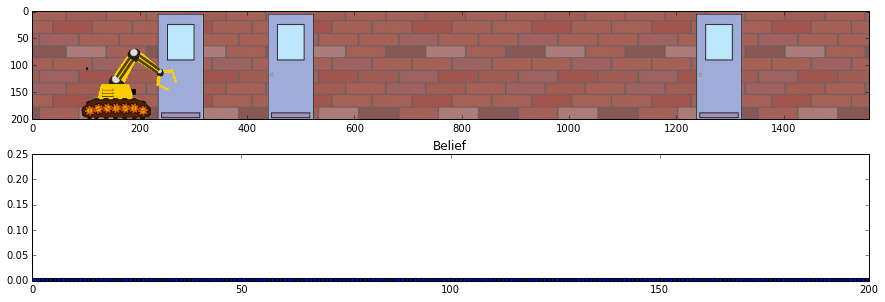

In [27]:
# belief is the list of grid cells
belief = np.array([1./n]*n)
# true state is the actual location of the robot
true_state = 180.5

f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,5))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Belief'); ax2.set_ylim([0, 0.25]); ax2.set_xlim([0, n]); ax2.bar(X, belief)

### Move right

<Container object of 200 artists>

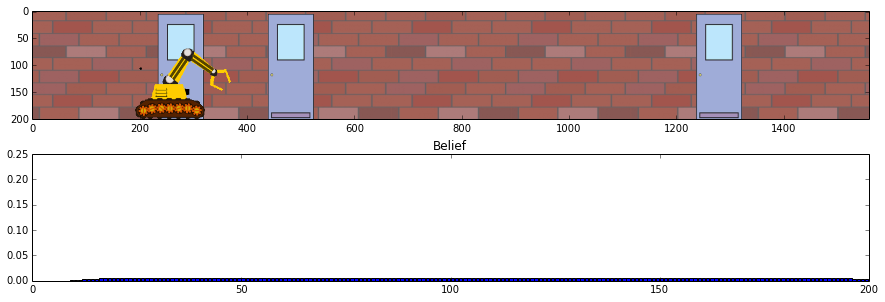

In [28]:
u = 100
true_state += u
belief = predict(belief, env_map, u + np.random.normal(scale=x_noise))

f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,5))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Belief'); ax2.set_ylim([0, 0.25]); ax2.set_xlim([0, n]); ax2.bar(X, belief)

### Sense for doors

<Container object of 200 artists>

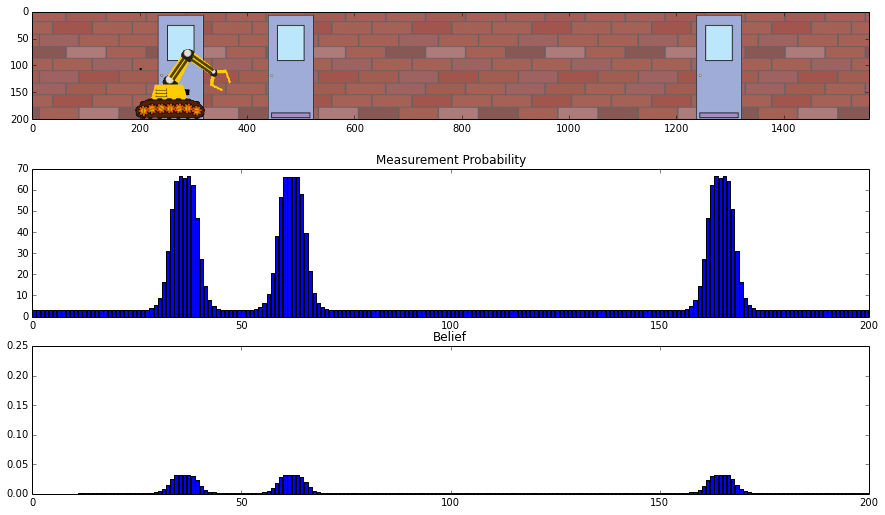

In [29]:
z = 0.015013100198017304 #get_measurement(true_state)
prob = measurement_probability(env_map, z)
belief = correct(belief, prob)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,9))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Measurement Probability'); ax2.set_xlim([0, n]); ax2.bar(X, prob)
ax3.set_title('Belief'); ax3.set_ylim([0, 0.25]); ax3.set_xlim([0, n]); ax3.bar(X, belief)

### Move right

<Container object of 200 artists>

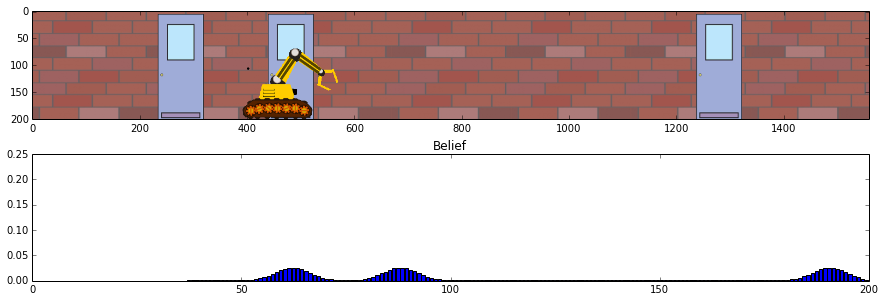

In [30]:
u = 200
true_state += u
belief = predict(belief, env_map, u + np.random.normal(scale=x_noise))

f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,5))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Belief'); ax2.set_ylim([0, 0.25]); ax2.set_xlim([0, n]); ax2.bar(X, belief)

### Sense for doors

<Container object of 200 artists>

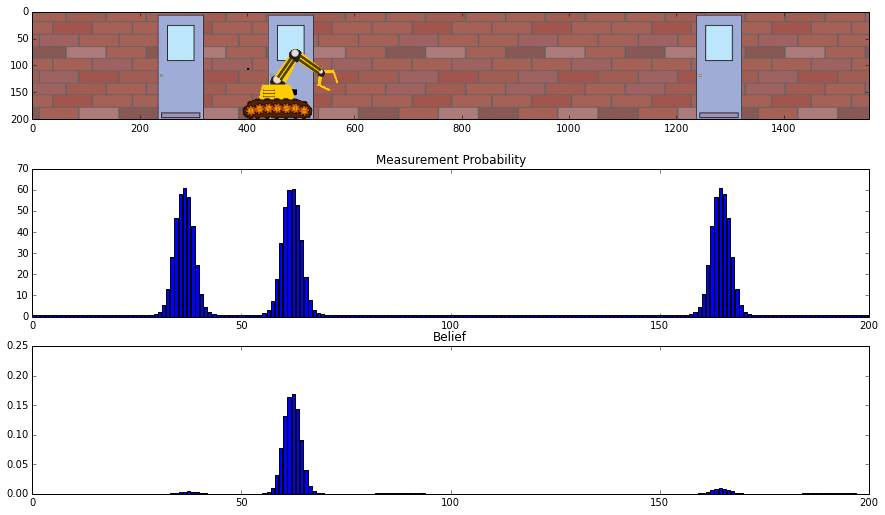

In [31]:
z = 0.018461221294540399 #get_measurement(true_state)
prob = measurement_probability(env_map, z)
belief = correct(belief, prob)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,9))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Measurement Probability'); ax2.set_xlim([0, n]); ax2.bar(X, prob)
ax3.set_title('Belief'); ax3.set_ylim([0, 0.25]); ax3.set_xlim([0, n]); ax3.bar(X, belief)

### Move right

<Container object of 200 artists>

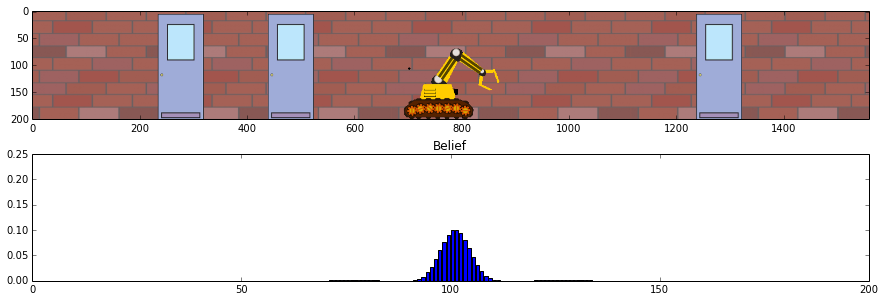

In [32]:
u = 300
true_state += u
belief = predict(belief, env_map, u + np.random.normal(scale=x_noise))

f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,5))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Belief'); ax2.set_ylim([0, 0.25]); ax2.set_xlim([0, n]); ax2.bar(X, belief)

### Sense for doors

<Container object of 200 artists>

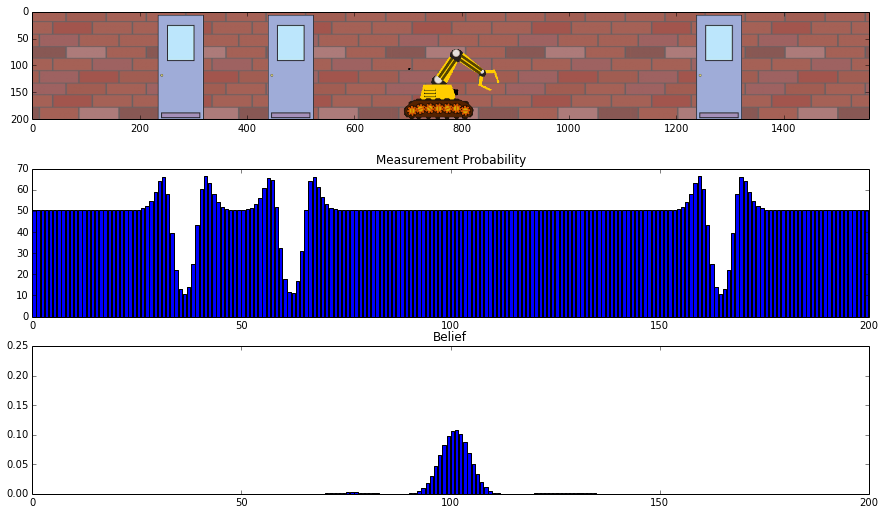

In [33]:
z = 0.0044673532993354101 # get_measurement(true_state)
prob = measurement_probability(env_map, z)
belief = correct(belief, prob)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,9))
x = int(true_state - w/2 + 0.5)
world = np.copy(doors_img)
world[70:70+h,x:x+w][robot_img[:,:,3]==1] = robot_img[robot_img[:,:,3]==1]
ax1.imshow(world)
ax2.set_title('Measurement Probability'); ax2.set_xlim([0, n]); ax2.bar(X, prob)
ax3.set_title('Belief'); ax3.set_ylim([0, 0.25]); ax3.set_xlim([0, n]); ax3.bar(X, belief)